using device: cuda:0

missing_keys: []
unexpected_keys: []


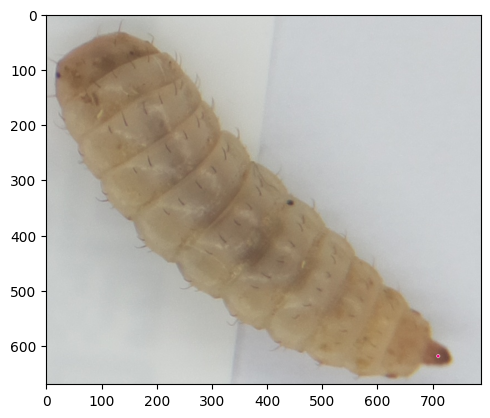

In [1]:
import os
import json

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from model import HighResolutionNet
from draw_utils import draw_keypoints
import transforms


def predict_bsf_single():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"using device: {device}")

    flip_test = True
    resize_hw = (256, 192)
    # img_path = "./bbox_vis/test_train.jpg"
    img_path="./test_result.jpg"
    weights_path = "./multi_train/best_model.pth"
    keypoint_json_path = "bsf_keypoints.json"
    assert os.path.exists(img_path), f"file: {img_path} does not exist."
    assert os.path.exists(weights_path), f"file: {weights_path} does not exist."
    assert os.path.exists(keypoint_json_path), f"file: {keypoint_json_path} does not exist."

    data_transform = transforms.Compose([
        transforms.AffineTransform(scale=(1.25, 1.25), fixed_size=resize_hw),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # read json file
    with open(keypoint_json_path, "r") as f:
        person_info = json.load(f)

    # read single-person image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor, target = data_transform(img, {"box": [0, 0, img.shape[1] - 1, img.shape[0] - 1]})
    img_tensor = torch.unsqueeze(img_tensor, dim=0)

    # create model
    # HRNet-W32: base_channel=32
    # HRNet-W48: base_channel=48
    # model = HighResolutionNet(base_channel=32,num_joints=2)
    # weights = torch.load(weights_path, map_location=device)
    # weights = weights if "model" not in weights else weights["model"]
    # model.load_state_dict(weights)
    # model.to(device)
    # model.eval()
    
     # ✨ 直接整体load，不是load_state_dict
    # model = torch.load(weights_path, map_location=device)
    # model.to(device)
    # model.eval()

    # 创建模型 ---------------------------------------------------------------
    model = HighResolutionNet(base_channel=32, num_joints=2)
    
    # 加载权重 ---------------------------------------------------------------
    weights = torch.load(weights_path, map_location=device)
    # print("权重文件键:", weights.keys())  # 调试输出
    
    # 自动识别权重结构
    if "state_dict" in weights:  # 常规checkpoint格式
        state_dict = weights["state_dict"]
    elif "model" in weights:     # 仅模型权重
        state_dict = weights["model"]
    else:                        # 直接使用
        state_dict = weights
    
    # 处理多GPU训练保存的权重
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    
    # 非严格模式加载
    missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
    print(f"\nmissing_keys: {missing_keys}")
    print(f"unexpected_keys: {unexpected_keys}")

    model.to(device)
    model.eval()
    with torch.inference_mode():
        outputs = model(img_tensor.to(device))

        if flip_test:
            flip_tensor = transforms.flip_images(img_tensor)
            flip_outputs = torch.squeeze(
                transforms.flip_back(model(flip_tensor.to(device)), person_info["flip_pairs"]),
            )
            # feature is not aligned, shift flipped heatmap for higher accuracy
            # https://github.com/leoxiaobin/deep-high-resolution-net.pytorch/issues/22
            flip_outputs[..., 1:] = flip_outputs.clone()[..., 0: -1]
            outputs = (outputs + flip_outputs) * 0.5

        keypoints, scores = transforms.get_final_preds(outputs, [target["reverse_trans"]], True)
        keypoints = np.squeeze(keypoints)
        scores = np.squeeze(scores)

        plot_img = draw_keypoints(img, keypoints, scores, thresh=0.2, r=3)
        plt.imshow(plot_img)
        plt.show()
        plot_img.save("test_result3.jpg")


if __name__ == '__main__':
    predict_bsf_single()


Using device: cuda:0
Number of keypoints: 2
missing_keys: []
unexpected_keys: []
Predicted keypoints:
 [[ 70.04712   60.850323]
 [729.31415  620.49475 ]]
Predicted scores:
 [0.6234203  0.82181656]


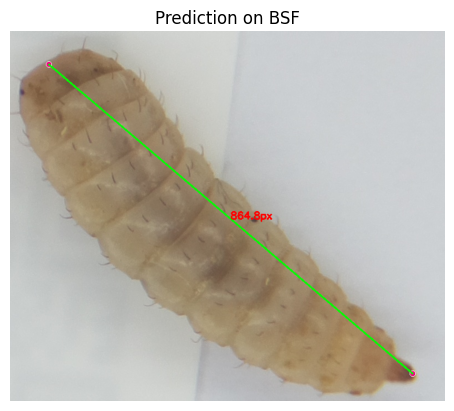

Prediction result saved to ./test_result.jpg


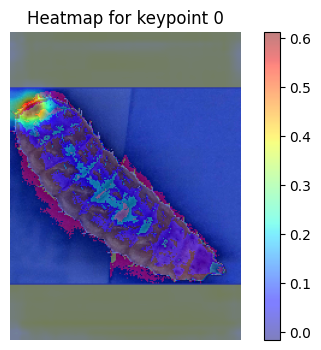

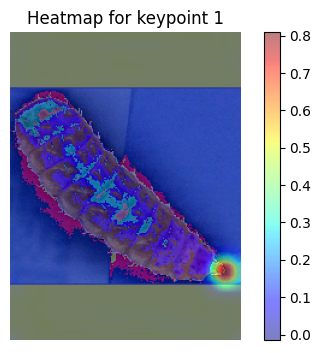

In [1]:
import os
import json
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from model import HighResolutionNet
from draw_utils import draw_keypoints
import transforms
import torchvision.transforms.functional as TF

def predict_bsf_single():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # ===== 配置参数 =====
    # img_path = "./test_little.png"
    # img_path = "./test_result.jpg"
    img_path="./test_result.jpg"
    weights_path = "./multi_train/model_epoch_7.pth"
    keypoint_json_path = "bsf_keypoints.json"
    resize_hw = (256, 192)
    flip_test = True

    # ===== 路径检查 =====
    assert os.path.exists(img_path), f"file: {img_path} does not exist."
    assert os.path.exists(weights_path), f"file: {weights_path} does not exist."
    assert os.path.exists(keypoint_json_path), f"file: {keypoint_json_path} does not exist."

    # ===== 加载配置 JSON =====
    with open(keypoint_json_path, "r") as f:
        bsf_info = json.load(f)

    kps_weights = bsf_info["kps_weights"]
    num_joints = len(kps_weights)
    print(f"Number of keypoints: {num_joints}")

    data_transform = transforms.Compose([
        # transforms.AffineTransform(scale=(1.25, 1.25), fixed_size=resize_hw),
        transforms.AffineTransform(scale=(1.0, 1.0), fixed_size=resize_hw),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # ===== 读取图像并预处理 =====
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor, target = data_transform(img, {"box": [0, 0, img.shape[1]-1, img.shape[0]-1]})
    img_tensor = torch.unsqueeze(img_tensor, dim=0)

    # ===== 加载模型 =====
    model = HighResolutionNet(base_channel=32, num_joints=num_joints)
    weights = torch.load(weights_path, map_location=device)
    weights = weights["model"] if "model" in weights else weights
    # 正确写法应该是：
    state_dict = weights
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
    print(f"missing_keys: {missing_keys}")
    print(f"unexpected_keys: {unexpected_keys}")

    model.load_state_dict(weights, strict=False)
    model.to(device)
    model.eval()

    with torch.inference_mode():
        outputs = model(img_tensor.to(device))

        if flip_test:
            flip_tensor = transforms.flip_images(img_tensor)
            flip_outputs = transforms.flip_back(model(flip_tensor.to(device)), bsf_info["flip_pairs"])
            flip_outputs[..., 1:] = flip_outputs.clone()[..., :-1]
            outputs = (outputs + flip_outputs) * 0.5

        keypoints, scores = transforms.get_final_preds(outputs, [target["reverse_trans"]], post_processing=True)
        keypoints = np.squeeze(keypoints)
        scores = np.squeeze(scores)

        print("Predicted keypoints:\n", keypoints)
        print("Predicted scores:\n", scores)

        # ===== Visualization key points =====
        result_img = draw_keypoints(img, keypoints, scores, thresh=0.2, r=5)
        result_img = np.array(result_img)  # PIL to np.array

        # The distance between the key points 0 and 1
        idx1, idx2 = 0, 1
        pt1 = tuple(keypoints[idx1].astype(int))
        pt2 = tuple(keypoints[idx2].astype(int))
        distance = np.linalg.norm(np.array(pt1) - np.array(pt2))
        
        # Draw the lines and mark the distances
        cv2.line(result_img, pt1, pt2, (0, 255, 0), 2)
        mid = ((pt1[0] + pt2[0]) // 2, (pt1[1] + pt2[1]) // 2)
        cv2.putText(result_img, f"{distance:.1f}px", mid, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        plt.title("Prediction on BSF")
        plt.imshow(result_img)
        plt.axis("off")
        plt.show()
        result_img = Image.fromarray(result_img)
        result_img.save("test_result3.jpg")

        print("Prediction result saved to ./test_result.jpg")

        # ===== heatmap =====
        heatmap_tensor = outputs[0]  # shape: [num_joints, H, W]
        resized_img = TF.to_pil_image(torch.squeeze(img_tensor.cpu()))
        resized_img = resized_img.resize((heatmap_tensor.shape[2]*4, heatmap_tensor.shape[1]*4))

        for j in range(num_joints):
            plt.figure(figsize=(6, 4))
            plt.title(f"Heatmap for keypoint {j}")
            heatmap = heatmap_tensor[j].cpu().numpy()
            heatmap = cv2.resize(heatmap, (resized_img.width, resized_img.height))
            plt.imshow(resized_img)
            plt.imshow(heatmap, alpha=0.5, cmap='jet')
            plt.colorbar()
            plt.axis('off')
            plt.show()

if __name__ == "__main__":
    predict_bsf_single()


In [38]:
import os
import json
import torch
import numpy as np
import cv2
from PIL import Image
from model import HighResolutionNet
from draw_utils import draw_keypoints
import transforms

def predict_folder(input_dir, output_dir):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    weights_path = "./multi_train/model_epoch_7.pth"
    keypoint_json_path = "bsf_keypoints.json"
    resize_hw = (256, 192)
    flip_test = True
    thresh = 0.3  # 关键点置信度阈值

    assert os.path.exists(weights_path), f"file: {weights_path} does not exist."
    assert os.path.exists(keypoint_json_path), f"file: {keypoint_json_path} does not exist."
    os.makedirs(output_dir, exist_ok=True)

    with open(keypoint_json_path, "r") as f:
        bsf_info = json.load(f)

    kps_weights = bsf_info["kps_weights"]
    num_joints = len(kps_weights)

    data_transform = transforms.Compose([
        transforms.AffineTransform(scale=(1.0, 1.0), fixed_size=resize_hw),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 模型加载
    model = HighResolutionNet(base_channel=32, num_joints=num_joints)
    weights = torch.load(weights_path, map_location=device)
    weights = weights["model"] if "model" in weights else weights
    state_dict = {k.replace("module.", ""): v for k, v in weights.items()}
    model.load_state_dict(state_dict, strict=False)
    model.to(device).eval()

    total = 0    # 图片总数
    found = 0    # 成功找到两点并保存的图片数

    image_idx = 0
    for filename in sorted(os.listdir(input_dir)):
        if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
            continue
   
        total += 1
        image_idx = total
        img_path = os.path.join(input_dir, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor, target = data_transform(img, {"box": [0, 0, img.shape[1]-1, img.shape[0]-1]})
        img_tensor = torch.unsqueeze(img_tensor, dim=0)

        with torch.inference_mode():
            outputs = model(img_tensor.to(device))

            if flip_test:
                flip_tensor = transforms.flip_images(img_tensor)
                flip_outputs = transforms.flip_back(
                    model(flip_tensor.to(device)), 
                    bsf_info["flip_pairs"]
                )
                flip_outputs[..., 1:] = flip_outputs.clone()[..., :-1]
                outputs = (outputs + flip_outputs) * 0.5

            keypoints, scores = transforms.get_final_preds(
                outputs, [target["reverse_trans"]], post_processing=True
            )
            keypoints = np.squeeze(keypoints)
            scores = np.squeeze(scores)

            # 索引 0 和 1 两个关键点
            idx1, idx2 = 0, 1
            if scores[idx1] < thresh or scores[idx2] < thresh:
                print(f"[未找到] 图片 `{filename}` (第 {image_idx} 张)，"
                      f"点0分数={scores[idx1]:.3f}, 点1分数={scores[idx2]:.3f}")
                continue  # 跳过该图的绘制和保存
            found += 1
            # 如果两个点都存在，则绘制并保存
            result_img = draw_keypoints(img, keypoints, scores, thresh=thresh, r=5)
            result_img = np.array(result_img)
            pt1 = tuple(keypoints[idx1].astype(int))
            pt2 = tuple(keypoints[idx2].astype(int))
            distance = np.linalg.norm(np.array(pt1) - np.array(pt2))
            cv2.line(result_img, pt1, pt2, (0, 255, 0), 2)
            mid = ((pt1[0] + pt2[0]) // 2, (pt1[1] + pt2[1]) // 2)
            cv2.putText(
                result_img, f"{distance:.1f}px", mid,
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2
            )

            save_path = os.path.join(output_dir, filename)
            Image.fromarray(result_img).save(save_path)
            print(f"Saved: {save_path}")
    if total > 0:
        pct = found / total * 100
        print(f"\n共处理图片：{total} 张，成功：{found} 张，成功率：{pct:.2f}%")
    else:
        print("输入目录中没有找到任何图片。")

# 调用示例
predict_folder("./data/chrop", "./already_test")


Using device: cuda:0
Saved: ./already_test/Snipaste_2025-05-13_16-49-25.png
Saved: ./already_test/Snipaste_2025-05-13_16-51-25.png
Saved: ./already_test/Snipaste_2025-05-13_16-51-47.png
Saved: ./already_test/Snipaste_2025-05-13_16-52-07.png
Saved: ./already_test/Snipaste_2025-05-13_16-52-25.png
Saved: ./already_test/Snipaste_2025-05-13_16-52-52.png
Saved: ./already_test/Snipaste_2025-05-13_16-53-07.png
Saved: ./already_test/Snipaste_2025-05-13_16-53-29.png
Saved: ./already_test/Snipaste_2025-05-13_16-53-49.png
Saved: ./already_test/Snipaste_2025-05-13_16-54-12.png
Saved: ./already_test/Snipaste_2025-05-13_16-54-42.png
Saved: ./already_test/Snipaste_2025-05-13_16-55-02.png
Saved: ./already_test/Snipaste_2025-05-13_16-55-13.png
Saved: ./already_test/Snipaste_2025-05-13_16-55-32.png
Saved: ./already_test/Snipaste_2025-05-13_16-55-46.png
Saved: ./already_test/Snipaste_2025-05-13_16-56-21.png
Saved: ./already_test/Snipaste_2025-05-13_16-56-35.png
Saved: ./already_test/Snipaste_2025-05-13_16

In [37]:
import os
import json
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from model import HighResolutionNet
from draw_utils import draw_keypoints
import transforms

def predict_bsf_single():
    # 硬件配置
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 配置参数 ----------------------------------------------------------------
    flip_test = True
    resize_hw = (512, 384)  # 调整为更大的输入尺寸
    img_path = "./test_result.jpg"
    weights_path = "./multi_train/model_epoch_7.pth"
    keypoint_json_path = "bsf_keypoints.json"
    
    # 可视化参数
    display_scale = 0.3  # 显示缩放比例（针对大尺寸图像）
    keypoint_radius = 15  # 关键点绘制半径
    line_thickness = 4    # 连接线粗细

    # 初始化检查 --------------------------------------------------------------
    assert all(os.path.exists(p) for p in [img_path, weights_path, keypoint_json_path]), "文件路径错误"

    # 数据预处理 --------------------------------------------------------------
    data_transform = transforms.Compose([
        transforms.AffineTransform(
            scale=(1.25, 1.25),  # 必须与训练时一致！
            fixed_size=resize_hw,
            # rotate_factor=30  # 如果训练时启用了旋转需要取消注释
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 读取关键点配置 ----------------------------------------------------------
    with open(keypoint_json_path, "r") as f:
        bsf_info = json.load(f)
    num_joints = 2  # 必须与训练时一致！

    # 图像处理流程 ------------------------------------------------------------
    # 读取原始图像
    orig_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    h, w = orig_img.shape[:2]
    print(f"原始图像尺寸: {w}x{h}")

    # 数据增强处理
    img_tensor, target = data_transform(
        orig_img.copy(),
        {"box": [0, 0, w-1, h-1]}  # 全图检测
    )
    img_tensor = torch.unsqueeze(img_tensor, 0)

    # 模型初始化 --------------------------------------------------------------
    model = HighResolutionNet(base_channel=32, num_joints=num_joints)
    
    # 权重加载（兼容不同保存格式）
    weights = torch.load(weights_path, map_location=device)
    if "model" in weights:
        model.load_state_dict(weights["model"], strict=False)
    else:
        model.load_state_dict(weights, strict=False)
    model.to(device)
    model.eval()

    # 预测流程 ----------------------------------------------------------------
    with torch.no_grad():
        # 前向传播
        outputs = model(img_tensor.to(device))
        print(f"模型输出尺寸: {outputs.shape}")

        # 翻转增强
        if flip_test:
            flip_tensor = transforms.flip_images(img_tensor)
            flip_outputs = torch.squeeze(
                transforms.flip_back(model(flip_tensor.to(device)), bsf_info["flip_pairs"]),
            )
            flip_outputs[..., 1:] = flip_outputs.clone()[..., 0:-1]
            outputs = (outputs + flip_outputs) * 0.5

        # 关键点解码
        keypoints, scores = transforms.get_final_preds(
            outputs, [target["reverse_trans"]], True
        )
        keypoints = np.squeeze(keypoints)
        scores = np.squeeze(scores)
        
        # 调试输出 ------------------------------------------------------------
        print("\n关键点原始输出:")
        print(f"Head坐标: ({keypoints[0][0]:.1f}, {keypoints[0][1]:.1f}) 置信度: {scores[0]:.3f}")
        print(f"Tail坐标: ({keypoints[1][0]:.1f}, {keypoints[1][1]:.1f}) 置信度: {scores[1]:.3f}")
        print(f"反向变换矩阵:\n{target['reverse_trans'][0]}")

    # 可视化部分 --------------------------------------------------------------
     # 原始绘制调用
    plot_img = draw_keypoints(
        orig_img,
        keypoints,
        scores,
        thresh=0.01,
        r=keypoint_radius
    )

    # 颜色替换逻辑
    red_color = np.array([255, 0, 0])  # BGR红色
    green_color = np.array([0, 255, 0])  # BGR绿色
    
    # 创建颜色掩膜
    red_mask = cv2.inRange(plot_img, red_color, red_color)
    
    # 应用颜色替换
    plot_img[red_mask > 0] = green_color
   
    # 创建显示副本（缩放显示）
    display_img = cv2.resize(plot_img, (0,0), fx=display_scale, fy=display_scale)
    
    # 可视化设置
    plt.figure(figsize=(16, 12))
    plt.title(f"BSF关键点检测 (显示缩放: {display_scale*100}%)")
    plt.imshow(display_img)
    plt.axis('off')
    
    # 保存全尺寸结果
    result_path = "detection_result.jpg"
    cv2.imwrite(result_path, cv2.cvtColor(plot_img, cv2.COLOR_RGB2BGR))
    print(f"\n结果已保存至: {result_path}")
    plt.show()

if __name__ == '__main__':
    predict_bsf_single()

Using device: cuda:0
原始图像尺寸: 788x670
模型输出尺寸: torch.Size([1, 2, 128, 96])

关键点原始输出:
Head坐标: (-98.4, -321.3) 置信度: -0.002
Tail坐标: (-26.5, -321.3) 置信度: 0.041
反向变换矩阵:
[ 10.27415144  -0.         -98.375     ]


error: OpenCV(4.5.4) :-1: error: (-5:Bad argument) in function 'inRange'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


Detected bbox: [2278.0, 1567.058823529412, 3066.2352941176473, 2237.6470588235293]
Using device: cuda:0
Predicted keypoints:
[[ 705.1067  -321.33334]
 [ -98.375   -321.33334]]
Predicted scores:
[ 0.10576094 -0.07203253]


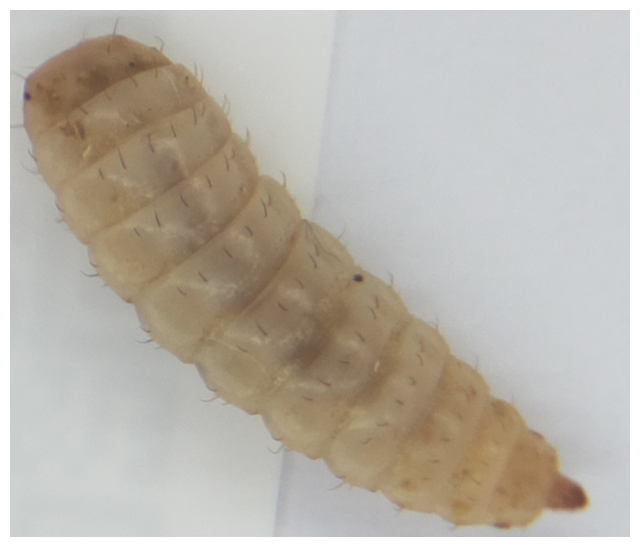

Saved prediction result to ./test_result.jpg


In [66]:
import os
import json
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

from model import HighResolutionNet
import transforms
from draw_utils import draw_keypoints


def extract_bbox_from_labelme(labelme_json_path):
    with open(labelme_json_path, "r") as f:
        labelme = json.load(f)
    
    for shape in labelme["shapes"]:
        if shape["label"] == "BSF" and shape["shape_type"] == "rectangle":
            (x1, y1), (x2, y2) = shape["points"]
            bbox = [x1, y1, x2, y2]
            break
    else:
        raise ValueError("No rectangle (BSF) found in labelme JSON")
    
    # 这里 imagePath 可以写死
    image_path = "./test.jpg"   # ← 改成你的实际图片路径
    return image_path, bbox


def predict_from_bbox(image_path, bbox, keypoint_json_path, weights_path, resize_hw=(256, 192), score_thresh=0.2):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 读取图片
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image at {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    x1, y1, x2, y2 = bbox
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
    crop_img = img[y1:y2, x1:x2, :]

    # 变换
    data_transform = transforms.Compose([
        transforms.AffineTransform(scale=(1.25, 1.25), fixed_size=resize_hw),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img_tensor, target = data_transform(crop_img, {"box": [0, 0, crop_img.shape[1]-1, crop_img.shape[0]-1]})
    img_tensor = img_tensor.unsqueeze(0).to(device)

    # 读json，得到num_joints
    with open(keypoint_json_path, "r") as f:
        kps_info = json.load(f)
    num_joints = len(kps_info["kps_weights"])

    # 模型
    model = HighResolutionNet(base_channel=32, num_joints=num_joints)
    weights = torch.load(weights_path, map_location=device)
    model.load_state_dict(weights, strict=False)
    model.to(device)
    model.eval()

    with torch.no_grad():
        outputs = model(img_tensor)
        keypoints, scores = transforms.get_final_preds(outputs, [target["reverse_trans"]], True)
        keypoints = np.squeeze(keypoints)
        scores = np.squeeze(scores)

    print("Predicted keypoints:")
    print(keypoints)
    print("Predicted scores:")
    print(scores)

    # ======== 绘制图像，加上"H"、"T" ========
    result_img = draw_keypoints(crop_img, keypoints, scores, thresh=score_thresh, r=5)

    # 如果是PIL，转成numpy
    if isinstance(result_img, Image.Image):
        result_img = np.array(result_img)

    # 加文字
    label_names = ["H", "T"]   # head 和 tail
    for idx, (x, y) in enumerate(keypoints):
        if scores[idx] >= score_thresh:
            x, y = int(x), int(y)
            cv2.putText(result_img, label_names[idx], (x + 5, y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    # 显示图像
    plt.figure(figsize=(8, 8))
    plt.imshow(result_img)
    plt.axis('off')
    plt.show()

    # 保存
    save_path = "./test_result.jpg"
    result_img_bgr = cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, result_img_bgr)
    print(f"Saved prediction result to {save_path}")


if __name__ == "__main__":
    # === Modify paths below ===
    labelme_json_path = "./test_labelme.json"
    keypoint_json_path = "./bsf_keypoints.json"
    weights_path = "./multi_train/model_epoch_7.pth"
    
    image_path, bbox = extract_bbox_from_labelme(labelme_json_path)
    print("Detected bbox:", bbox)
    predict_from_bbox(image_path, bbox, keypoint_json_path, weights_path)
